In [53]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt
import math
import tqdm
import matplotlib.dates as mdates

pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
async_folder = "logs/11_H"
sync_folder = "logs/13_J"

experiment_phases = [0, 600_000, 1_200_000, 1_800_000]
function_colors = {
    "check": "blue",
    "virus": "orange",
    "ocr": "green",
    "email": "red",
    "urgentcheck": "blue",
    "urgentvirus": "orange",
    "urgentocr": "green",
    "urgentemail": "red"
}
cpu_color = "black"


In [56]:

overall_min_unix_time = 9223372036854775807 # Too big, please don't run after Tue Oct 07 4892 21:52:48 GMT+0000
overall_max_unix_time = 0 # Please don't run this experiment before Thu Jan 01 1970 00:00:00 GMT+0000
def get_df_from_folder(folder):
    global overall_min_unix_time
    global overall_max_unix_time
    lines = []
    k6_durations = []
    for file_name in glob.glob("*.log", root_dir=folder):
        with open(folder + "/" + file_name) as f:
            while line := f.readline():
                if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                    json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                    try:
                        lines.append(json.loads(json_string))
                    except:
                        print("Error in file: " + file_name)
                        print("Line: " + line)
                        print("JSON: " + json_string)
                        print("-----")
                        continue
                if "K6MAGICSTRING" in line:
                    raw_data = re.search(r'K6MAGICSTRING(.*?)K7MAGICSTRING', line).group(1)
                    splits = raw_data.split(",")
                    req_duration = None
                    callid = None
                    try:
                        req_duration = float(splits[2].strip())
                        callid = splits[1].strip()
                    except:
                        req_duration = float(splits[1].strip())
                        callid = splits[2].strip()
                    k6_durations.append({
                        "start_unix": float(splits[0].strip()),
                        "req_duration": req_duration,
                        "callid": callid,
                    })


    df = pd.DataFrame(lines)
    # Convert type to float
    df["start"] = df["start"].astype(float)
    df["end"] = df["end"].astype(float)
    df["request_timestamp"] = df["request_timestamp"].astype(float)
    df["request_deadline"] = df["request_deadline"].astype(float)


    # Calculate Durations
    cut_off_after_cpu_load = True
    if cut_off_after_cpu_load:
        max_start_time = df["start"] + experiment_phases[3]
        df = df[df["start"] < max_start_time]

    overall_max_unix_time = max(overall_max_unix_time, df["end"].max())
    
    # get k6 data as well
    k6_df = pd.DataFrame(k6_durations)

    exp_min_unix_time = k6_df["start_unix"].min()
    overall_min_unix_time = min(overall_min_unix_time, exp_min_unix_time)
    
    k6_df["req_duration_td"] = pd.to_timedelta(k6_df["req_duration"], unit="ms")
    k6_df["start_rel"] = pd.to_datetime(k6_df["start_unix"] - exp_min_unix_time, unit="ms")
    k6_df["end_rel"] = k6_df["start_rel"] + k6_df["req_duration_td"]


    df["request_timestamp_rel"] = pd.to_datetime(df["request_timestamp"] - overall_min_unix_time, unit="ms")
    df["request_deadline_rel"] = pd.to_datetime(df["request_deadline"] - overall_min_unix_time, unit="ms")
    df["start_rel"] = pd.to_datetime(df["start"] - overall_min_unix_time, unit="ms")
    df["end_rel"] = pd.to_datetime(df["end"] - overall_min_unix_time, unit="ms")

    # Set Correct Data Types
    df["start_dt"] = pd.to_datetime(df["start"], unit="ms")
    df["end_dt"] = pd.to_datetime(df["end"], unit="ms")
    df["request_timestamp_dt"] = pd.to_datetime(df["request_timestamp"], unit="ms")
    df["request_deadline_dt"] = pd.to_datetime(df["request_deadline"], unit="ms")

    # Add new columns
    df["run_duration"] = df["end"] - df["start"]
    df["time_to_deadline"] = df["request_deadline"] - df["start"]
    df["init_duration"] = df["start"] - df["request_timestamp"]
    df = df.sort_values(by=["function", "start"])
    df["__start_diff"] = df.groupby("function")["start"].diff()
    df['line_segment'] = (df['__start_diff'] > 5000).cumsum() # create a new line segment if there is a 5 second break

    return (df, k6_df, exp_min_unix_time)

(sync_df, sync_k6_df, sync_min_unix) = get_df_from_folder(sync_folder)
(async_df, async_k6_df, async_min_unix) = get_df_from_folder(async_folder)
sync_df = sync_df[sync_df["function"].str.contains("urgent", regex=False)]
sync_df["experiment"] = "sync"
async_df["experiment"] = "async"
df = pd.concat([sync_df, async_df])
sync_k6_df["experiment"] = "sync"
async_k6_df["experiment"] = "async"
k6_df = pd.concat([sync_k6_df, async_k6_df])


In [57]:
print(f"Sync experiment started on {pd.to_datetime(sync_min_unix, unit='ms')} and ended on {pd.to_datetime(sync_df['end'].max(), unit='ms')}")
print(f"Async experiment started on {pd.to_datetime(async_min_unix, unit='ms')} and ended on {pd.to_datetime(async_df['end'].max(), unit='ms')}")

Sync experiment started on 2023-09-20 12:56:46.105999872 and ended on 2023-09-20 13:27:17.310943744
Async experiment started on 2023-09-19 15:46:47.841999872 and ended on 2023-09-19 16:20:28.822068480


In [58]:
# If you want all CPU usage values in the df set this to False
ONLY_RELEVANT_CPU = True

__smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    # if ONLY_RELEVANT_CPU:
    #     start_ts = int(file_name.split("_")[3].split(".")[0])
    #     if start_ts > last_experiment_timestamp or start_ts < min_timestamp - 1000*60*60*24:
    #         continue
    with open("usage/" + file_name) as f:
        __smaller_dfs.append(pd.read_csv(f))
usage_df = pd.concat(__smaller_dfs)
usage_df["unix_time_dt"] = pd.to_datetime(usage_df["unix_time"], unit="ms")
# usage_df["experiment_time"] = usage_df["unix_time"] - min_timestamp

# if ONLY_RELEVANT_CPU:
#     # Delete all values 10 seconds after the last call ended and 10 seconds before the first call started
#     print("removed before:" + str(len(usage_df[usage_df["unix_time"] <= (last_experiment_timestamp)])))
#     usage_df = usage_df[usage_df["unix_time"] <= (last_experiment_timestamp)]
#     print("removed after:" + str(len(usage_df[usage_df["unix_time"] >= (min_timestamp)])))
#     usage_df = usage_df[usage_df["unix_time"] >= (min_timestamp)]

async_usage_df = usage_df[(usage_df["unix_time"] > async_min_unix) & (usage_df["unix_time"] < async_df["end"].max())]
async_usage_df["experiment_time_rel"] = pd.to_datetime(async_usage_df["unix_time"] - async_min_unix, unit="ms")
async_usage_df["experiment"] = "async"
sync_usage_df = usage_df[(usage_df["unix_time"] > sync_min_unix) & (usage_df["unix_time"] < sync_df["end"].max())]
sync_usage_df["experiment_time_rel"] = pd.to_datetime(sync_usage_df["unix_time"] - sync_min_unix, unit="ms")
sync_usage_df["experiment"] = "sync"
usage_df = pd.concat([async_usage_df, sync_usage_df])

In [59]:
print(f"Sync usage goes from {sync_usage_df['unix_time_dt'].min()} and ended on {sync_usage_df['unix_time_dt'].max()}")
print(f"Async usage goes from {async_usage_df['unix_time_dt'].min()} and ended on {async_usage_df['unix_time_dt'].max()}")

Sync usage goes from 2023-09-20 12:56:48.077000 and ended on 2023-09-20 13:27:16.250000
Async usage goes from 2023-09-19 15:46:48.032000 and ended on 2023-09-19 16:20:27.530000


In [61]:
def get_workflow_from_df(df, k6_df, experiment):
    df = df.copy()
    df["__arbitrary_start"] = df["request_timestamp_rel"]
    df["__arbitrary_start"].fillna(df["start_rel"])
    df["total_run_duration"] = df["end_rel"] - df["__arbitrary_start"]
    df["total_run_duration_td"] = pd.to_timedelta(df["total_run_duration"], unit="ms")
    worfklow_list = []

    # for id in df["callid"].unique():
    #     workflow_info = {
    #         'start_rel': df[df["callid"] == id]["start_rel"].min(),
    #         'end_rel': df[df["callid"] == id]["end_rel"].max(),
    #         'num_swamped': len(df[(df["callid"] == id) & df["mode"] == "swamped"]),
    #         'run_duration': df[df["callid"] == id]["run_duration"].sum(),
    #         'total_run_duration_td': df[df["callid"] == id]["total_run_duration_td"].sum(),
    #         'request_sent_rel': k6_df[k6_df["callid"] == id]["start_rel"].min(), # its only one value, but who counts anyway
    #         'request_duration_rel': k6_df[k6_df["callid"] == id]["req_duration_td"].sum(), # also only one value
    #     }
    #     worfklow_list.append(workflow_info)

    # repeat above for loop with a loop comprehension
    worfklow_list = [
        {
            'start_rel': df[df["callid"] == id]["start_rel"].min(),
            'end_rel': df[df["callid"] == id]["end_rel"].max(),
            'num_swamped': len(df[(df["callid"] == id) & df["mode"] == "swamped"]),
            'run_duration': df[df["callid"] == id]["run_duration"].sum(),
            'total_run_duration_td': df[df["callid"] == id]["total_run_duration_td"].sum(),
            'request_sent_rel': k6_df[k6_df["callid"] == id]["start_rel"].min(), # its only one value, but who counts anyway
            'request_duration_rel': k6_df[k6_df["callid"] == id]["req_duration_td"].sum(), # also only one value
            'experiment': experiment
        }
        for id in tqdm.tqdm(df["callid"].unique(), desc=df["experiment"].iloc[0])
    ]

    return pd.DataFrame(worfklow_list)
sync_workflow_df = get_workflow_from_df(sync_df, sync_k6_df, "sync")
async_workflow_df = get_workflow_from_df(async_df, async_k6_df, "async")
workflow_df = pd.concat([sync_workflow_df, async_workflow_df])

sync:   0%|          | 0/1801 [00:00<?, ?it/s]

async: 100%|██████████| 1801/1801 [00:15<00:00, 112.75it/s]


In [63]:
sync_usage_df

,unix_time,cpu_percent,ram_percent,unix_time_dt,experiment_time_rel,experiment
30,1695214608077,90.45,6.54,2023-09-20 12:56:48.077,1970-01-01 00:00:01.971,sync
31,1695214610090,89.48,6.53,2023-09-20 12:56:50.090,1970-01-01 00:00:03.984,sync
32,1695214612109,86.07,6.53,2023-09-20 12:56:52.109,1970-01-01 00:00:06.003,sync
33,1695214614126,89.17,6.54,2023-09-20 12:56:54.126,1970-01-01 00:00:08.020,sync
34,1695214616153,93.67,6.58,2023-09-20 12:56:56.153,1970-01-01 00:00:10.047,sync
...,...,...,...,...,...,...
930,1695216428209,16.25,6.97,2023-09-20 13:27:08.209,1970-01-01 00:30:22.103,sync
931,1695216430219,10.06,6.97,2023-09-20 13:27:10.219,1970-01-01 00:30:24.113,sync
932,1695216432229,5.59,6.98,2023-09-20 13:27:12.229,1970-01-01 00:30:26.123,sync
933,1695216434239,5.83,6.97,2023-09-20 13:27:14.239,1970-01-01 00:30:28.133,sync


In [64]:
sync_usage_rolling_df = sync_usage_df[["experiment_time_rel", "cpu_percent", "ram_percent"]].rolling("60s", on="experiment_time_rel").mean()
sync_usage_rolling_df["experiment"] = "sync"
async_usage_rolling_df = async_usage_df[["experiment_time_rel", "cpu_percent", "ram_percent"]].rolling("60s", on="experiment_time_rel").mean()
async_usage_rolling_df["experiment"] = "async"
usage_rolling_df = pd.concat([sync_usage_rolling_df, async_usage_rolling_df])

<Axes: xlabel='experiment_time_rel', ylabel='cpu_percent'>

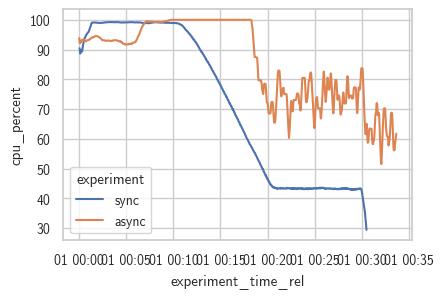

In [65]:
sns.lineplot(usage_rolling_df, x="experiment_time_rel", y="cpu_percent", hue="experiment")

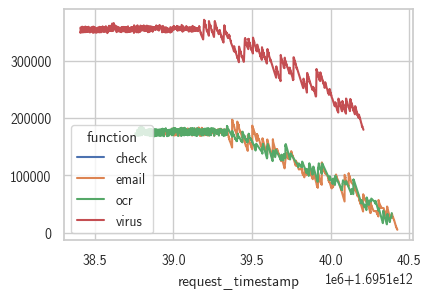

<Axes: xlabel='request_timestamp'>

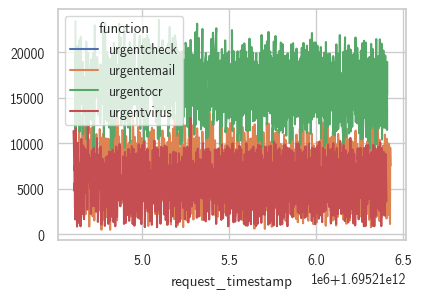

In [66]:
sns.lineplot(data=async_df, x="request_timestamp", y=async_df["start"]-async_df["request_timestamp"], hue="function")
plt.show()
sns.lineplot(data=sync_df, x="request_timestamp", y=sync_df["start"]-sync_df["request_timestamp"], hue="function")

In [67]:

# for (function, segment), group in tqdm.tqdm(sync_df.groupby(["function", "line_segment"])):
#     sns.lineplot(data=group, x="start_rel", y="run_duration", color=function_colors[function], errorbar="ci", label=function, legend="brief")
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
# ax2 = plt.twinx()
# sns.lineplot(sync_usage_rolling_df, x="experiment_time_rel", y="cpu_percent")

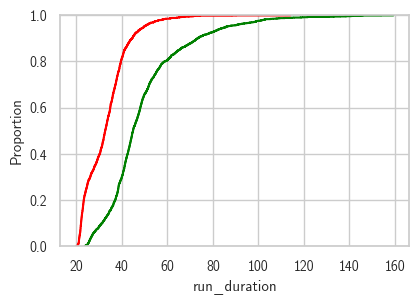

<Axes: xlabel='run_duration', ylabel='Proportion'>

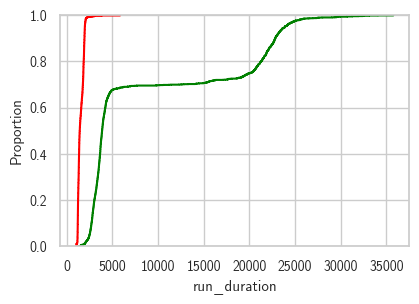

In [82]:
sns.ecdfplot(data=async_df[async_df["function"] == "check"], x="run_duration", color="green", label="Async")
sns.ecdfplot(data=sync_df[sync_df["function"] == "urgentcheck"], x="run_duration", color="red", label="Sync")
plt.show()
sns.ecdfplot(data=async_df[async_df["function"] == "ocr"], x="run_duration", color="green", label="Async")
sns.ecdfplot(data=sync_df[sync_df["function"] == "urgentocr"], x="run_duration", color="red", label="Sync")

100%|██████████| 600/600 [00:00<00:00, 598047.15it/s]
600it [00:00, 14189.84it/s]


<Axes: xlabel='experiment_time_rel', ylabel='load_percent'>

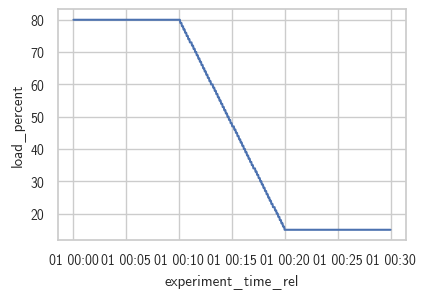

In [69]:
def get_cpu_share(start, end, current):
    # get the length of the experiment
    length = end - start
    # get the current time in the experiment
    current = current - start

    # if the current time is in the first third of the experiment
    if current < length/3:
        return "0.80"
    # if the current time is in the last third of the experiment
    elif current > 2*length/3:
        return "0.15"
    # if the current time is in the middle third of the experiment
    else:
        # calculate the cpu share based on the current time
        return str(round(((-1.95/length)*current + 1.45), 2))
        # the value if you want to go from 50 to 15:
        # return str(round(((-105/length)*current + 85)/100, 2))

artificial_cpu_load = [float(get_cpu_share(0, experiment_phases[3], i)) * 100 for i in tqdm.tqdm(range(0, experiment_phases[3], 3000))]
art_cpu_df = pd.DataFrame([{'load_percent': i, 'experiment_time': idx * 3000, 'experiment_time_rel': pd.to_datetime(idx * 3000, unit="ms")} for idx, i in tqdm.tqdm(enumerate(artificial_cpu_load))])
sns.lineplot( data=art_cpu_df,x="experiment_time_rel", y="load_percent",)

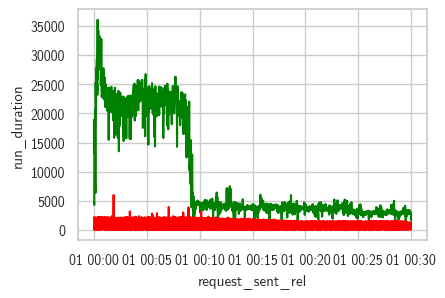

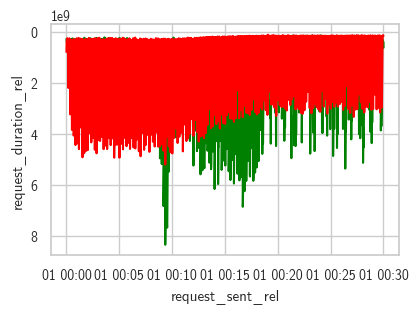

<Axes: xlabel='request_duration_rel', ylabel='Proportion'>

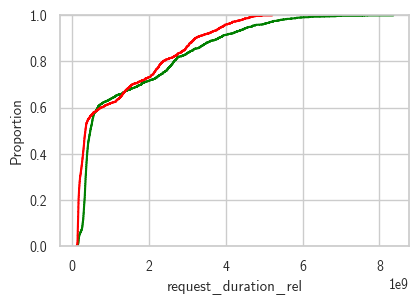

In [81]:
sns.lineplot(data=async_workflow_df, x="request_sent_rel", y="run_duration", color="green")
sns.lineplot(data=sync_workflow_df, x="request_sent_rel", y="run_duration", color="red")
plt.show()
sns.lineplot(data=async_workflow_df, x="request_sent_rel", y="request_duration_rel", color="green")
sns.lineplot(data=sync_workflow_df, x="request_sent_rel", y="request_duration_rel", color="red")
plt.show()
sns.ecdfplot(data=async_workflow_df, x="request_duration_rel", color="green")
sns.ecdfplot(data=sync_workflow_df, x="request_duration_rel", color="red")

In [78]:
async_concurrent_requests = [(len(async_df[(async_df["start"] <= i) & (async_df["end"] >= i)])) for i in tqdm.trange(int(async_df["start"].min()), int(async_df["end"].max()), 10_000)]
sync_concurrent_requests = [(len(sync_df[(sync_df["start"] <= i) & (sync_df["end"] >= i)])) for i in tqdm.trange(int(sync_df["start"].min()), int(sync_df["end"].max()), 10_000)]

100%|██████████| 184/184 [00:00<00:00, 4673.55it/s]


<Axes: >

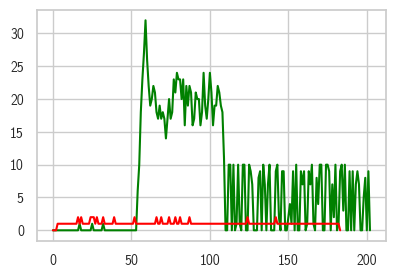

In [79]:
sns.lineplot(async_concurrent_requests, color="green")
sns.lineplot(sync_concurrent_requests, color="red")

# Actual Paper Grpfash

In [73]:
import matplotlib as mpl
sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,3)
mpl.rcParams['figure.dpi'] = 100

def save_fig(ax, name, file_type="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()
    file_name = name + "." + file_type
    fig.savefig(os.path.join("graphs", file_name), bbox_inches='tight')

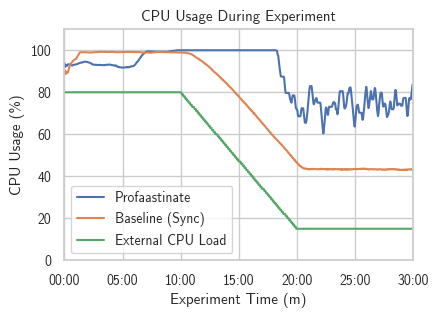

In [77]:
sns.lineplot(async_usage_rolling_df, x="experiment_time_rel", y="cpu_percent", label="Profaastinate")
sns.lineplot(sync_usage_rolling_df, x="experiment_time_rel", y="cpu_percent", label="Baseline (Sync)")
sns.lineplot(data=art_cpu_df, x="experiment_time_rel", y="load_percent", label="External CPU Load")
plt.ylim(0, 110)
plt.xlim(pd.to_datetime(0, unit="ms"), pd.to_datetime(experiment_phases[3], unit="ms"))
plt.ylabel("CPU Usage (%)")
plt.xlabel("Experiment Time (m)")
plt.title("CPU Usage During Experiment")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ac = plt.gca()
#plt.savefig("graphs/cpu_usage.pdf")
plt.show()
